# Import Libraries

In [1]:
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords, wordnet
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Suppressing warnings
warnings.filterwarnings('ignore')


# Create a SentimentIntensityAnalyzer 'sia' using VADER lexicon

In [2]:
import nltk
nltk.download('vader_lexicon')
#from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/swayamprava/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Create a random dataset of 60k with polarity 0,2,4

#### 0 = negative, 2 = neutral,  4 = positive

In [3]:
#from random import shuffle

def classify_sentiment(row):
    score = sia.polarity_scores(row['text'])
    if score['compound'] >= 0.05:
        return 4  # Positive
    elif score['compound'] <= -0.05:
        return 0  # Negative
    else:
        return 2  # Neutral

# Load the dataset
df = pd.read_csv('training.1600000.processed.noemotion.csv', header=None, encoding='latin-1')
df.columns = ['polarity', 'id', 'date', 'query', 'user', 'text']

# Apply VADER to classify tweets
df['polarity'] = df.apply(classify_sentiment, axis=1)

# Filter and sample the tweets
negative_tweets = df[df['polarity'] == 0]
positive_tweets = df[df['polarity'] == 4]
neutral_tweets = df[df['polarity'] == 2]

#sample 20,000 from each category
negative_sample = negative_tweets.sample(n=20000, random_state=42)
positive_sample = positive_tweets.sample(n=20000, random_state=42)
neutral_sample = neutral_tweets.sample(n=20000, random_state=42)

# Combine and shuffle
balanced_dataset = pd.concat([negative_sample, positive_sample, neutral_sample])
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)


# Save or display the data
balanced_dataset.to_csv('balanced_dataset_three_classes.csv', index=False)
print(balanced_dataset.head())


   polarity          id                          date     query  \
0         0  2249354965  Fri Jun 19 22:10:32 PDT 2009  NO_QUERY   
1         4  2251397506  Sat Jun 20 03:22:27 PDT 2009  NO_QUERY   
2         4  1469220718  Tue Apr 07 05:39:28 PDT 2009  NO_QUERY   
3         0  1685695518  Sun May 03 01:36:27 PDT 2009  NO_QUERY   
4         0  1970686901  Sat May 30 04:50:47 PDT 2009  NO_QUERY   

            user                                               text  
0    onerainyday   still walking... wish i knew what was wrong w...  
1      ICheetahI  We saw the cutest (other than Gremlin and Gizm...  
2         Illy02               @illy5G i love ur backround pic...    
3  _MatthewShaw_  all that pizza yesterday has left me feeling s...  
4     Thunderous  @cherryroad I haven't watched any Ten episodes...  


In [4]:
balanced_dataset.head(10)

,polarity,id,date,query,user,text
0,0,2249354965,Fri Jun 19 22:10:32 PDT 2009,NO_QUERY,onerainyday,still walking... wish i knew what was wrong w...
1,4,2251397506,Sat Jun 20 03:22:27 PDT 2009,NO_QUERY,ICheetahI,We saw the cutest (other than Gremlin and Gizm...
2,4,1469220718,Tue Apr 07 05:39:28 PDT 2009,NO_QUERY,Illy02,@illy5G i love ur backround pic...
3,0,1685695518,Sun May 03 01:36:27 PDT 2009,NO_QUERY,_MatthewShaw_,all that pizza yesterday has left me feeling s...
4,0,1970686901,Sat May 30 04:50:47 PDT 2009,NO_QUERY,Thunderous,@cherryroad I haven't watched any Ten episodes...
5,2,2257153821,Sat Jun 20 13:52:57 PDT 2009,NO_QUERY,jclwilson,@tina_3192 ouch my ears
6,0,1565156720,Mon Apr 20 06:03:02 PDT 2009,NO_QUERY,kaylanadeau,have a huge headache &amp; sore throat today ...
7,0,2235421822,Fri Jun 19 01:10:22 PDT 2009,NO_QUERY,kelly_erinn,being forced to watch saw. not looking forward...
8,0,1974353007,Sat May 30 12:57:39 PDT 2009,NO_QUERY,bpirtle,gosh....i hate shopping! stupid people being m...
9,4,1792537039,Wed May 13 23:26:13 PDT 2009,NO_QUERY,cmperezsocal,I love humpday


In [5]:
balanced_dataset

,polarity,id,date,query,user,text
0,0,2249354965,Fri Jun 19 22:10:32 PDT 2009,NO_QUERY,onerainyday,still walking... wish i knew what was wrong w...
1,4,2251397506,Sat Jun 20 03:22:27 PDT 2009,NO_QUERY,ICheetahI,We saw the cutest (other than Gremlin and Gizm...
2,4,1469220718,Tue Apr 07 05:39:28 PDT 2009,NO_QUERY,Illy02,@illy5G i love ur backround pic...
3,0,1685695518,Sun May 03 01:36:27 PDT 2009,NO_QUERY,_MatthewShaw_,all that pizza yesterday has left me feeling s...
4,0,1970686901,Sat May 30 04:50:47 PDT 2009,NO_QUERY,Thunderous,@cherryroad I haven't watched any Ten episodes...
...,...,...,...,...,...,...
59995,2,2014733992,Wed Jun 03 02:30:35 PDT 2009,NO_QUERY,NameInAHat,Mark from Name In A Hat is wondering where the...
59996,4,1759610024,Sun May 10 19:35:33 PDT 2009,NO_QUERY,OMGitsAndrea,"@kathryntft ahhh man, THAT SUCKS! but alright..."
59997,0,2244414725,Fri Jun 19 14:42:56 PDT 2009,NO_QUERY,Susie_Fairchild,Apologizing to all those who got an email from...
59998,0,2253040964,Sat Jun 20 07:28:34 PDT 2009,NO_QUERY,robbiewhitee,fuck work. I wanna see my dog


In [6]:
balanced_dataset.shape

(60000, 6)

In [7]:
# Count the occurrences of each sentiment label
sentiment_counts = balanced_dataset['polarity'].value_counts()

# Print the counts
print(sentiment_counts)

polarity
0    20000
4    20000
2    20000
Name: count, dtype: int64


# Sentiment Caterory Distribution Plot

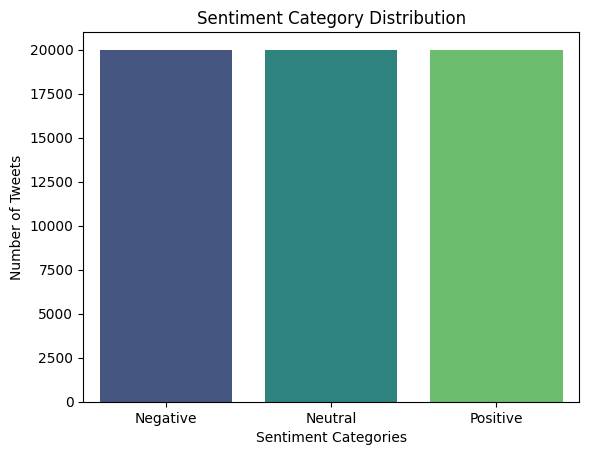

In [8]:
# Create a bar plot
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')

# Adding titles and labels
plt.title('Sentiment Category Distribution')
plt.xlabel('Sentiment Categories')
plt.ylabel('Number of Tweets')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])  # Assuming 0 = Negative, 2 = Neutral, 4 = Positive

# Show the plot
plt.show()

# Data Cleaning 

In [9]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove HTML tags
    tweet = re.sub(r'<.*?>', '', tweet)
    # Remove everything that is not letters
    tweet = re.sub(r'[^a-zA-Z]', ' ', tweet)
    # Tokenize text
    tweet_tokens = word_tokenize(tweet)
    # Remove stopwords
    filtered_words = [word.lower() for word in tweet_tokens if word.lower() not in stopwords.words('english')]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    return " ".join(lemmatized_words)


# Example usage
example_tweet = "Hello world! Check this out: https://example.com 😊 @user #amazing"
cleaned_tweet = clean_tweet(example_tweet)
print(cleaned_tweet)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/swayamprava/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/swayamprava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/swayamprava/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


hello world check amazing


In [10]:
balanced_dataset

,polarity,id,date,query,user,text
0,0,2249354965,Fri Jun 19 22:10:32 PDT 2009,NO_QUERY,onerainyday,still walking... wish i knew what was wrong w...
1,4,2251397506,Sat Jun 20 03:22:27 PDT 2009,NO_QUERY,ICheetahI,We saw the cutest (other than Gremlin and Gizm...
2,4,1469220718,Tue Apr 07 05:39:28 PDT 2009,NO_QUERY,Illy02,@illy5G i love ur backround pic...
3,0,1685695518,Sun May 03 01:36:27 PDT 2009,NO_QUERY,_MatthewShaw_,all that pizza yesterday has left me feeling s...
4,0,1970686901,Sat May 30 04:50:47 PDT 2009,NO_QUERY,Thunderous,@cherryroad I haven't watched any Ten episodes...
...,...,...,...,...,...,...
59995,2,2014733992,Wed Jun 03 02:30:35 PDT 2009,NO_QUERY,NameInAHat,Mark from Name In A Hat is wondering where the...
59996,4,1759610024,Sun May 10 19:35:33 PDT 2009,NO_QUERY,OMGitsAndrea,"@kathryntft ahhh man, THAT SUCKS! but alright..."
59997,0,2244414725,Fri Jun 19 14:42:56 PDT 2009,NO_QUERY,Susie_Fairchild,Apologizing to all those who got an email from...
59998,0,2253040964,Sat Jun 20 07:28:34 PDT 2009,NO_QUERY,robbiewhitee,fuck work. I wanna see my dog


In [11]:
# Applying the cleaning function to the 'text' column
balanced_dataset['cleaned_text'] = balanced_dataset['text'].apply(clean_tweet)

# Save the cleaned dataset
balanced_dataset.to_csv('balanced_dataset_cleaned.csv', index=False)

# Display the first few rows to inspect the cleaning
print(balanced_dataset.head())


   polarity          id                          date     query  \
0         0  2249354965  Fri Jun 19 22:10:32 PDT 2009  NO_QUERY   
1         4  2251397506  Sat Jun 20 03:22:27 PDT 2009  NO_QUERY   
2         4  1469220718  Tue Apr 07 05:39:28 PDT 2009  NO_QUERY   
3         0  1685695518  Sun May 03 01:36:27 PDT 2009  NO_QUERY   
4         0  1970686901  Sat May 30 04:50:47 PDT 2009  NO_QUERY   

            user                                               text  \
0    onerainyday   still walking... wish i knew what was wrong w...   
1      ICheetahI  We saw the cutest (other than Gremlin and Gizm...   
2         Illy02               @illy5G i love ur backround pic...     
3  _MatthewShaw_  all that pizza yesterday has left me feeling s...   
4     Thunderous  @cherryroad I haven't watched any Ten episodes...   

                                        cleaned_text  
0  still walking wish knew wrong throat dry leg numb  
1  saw cutest gremlin gizmo ferret ever want bad ...  
2    

In [12]:
balanced_dataset

,polarity,id,date,query,user,text,cleaned_text
0,0,2249354965,Fri Jun 19 22:10:32 PDT 2009,NO_QUERY,onerainyday,still walking... wish i knew what was wrong w...,still walking wish knew wrong throat dry leg numb
1,4,2251397506,Sat Jun 20 03:22:27 PDT 2009,NO_QUERY,ICheetahI,We saw the cutest (other than Gremlin and Gizm...,saw cutest gremlin gizmo ferret ever want bad ...
2,4,1469220718,Tue Apr 07 05:39:28 PDT 2009,NO_QUERY,Illy02,@illy5G i love ur backround pic...,love ur backround pic
3,0,1685695518,Sun May 03 01:36:27 PDT 2009,NO_QUERY,_MatthewShaw_,all that pizza yesterday has left me feeling s...,pizza yesterday left feeling ill
4,0,1970686901,Sat May 30 04:50:47 PDT 2009,NO_QUERY,Thunderous,@cherryroad I haven't watched any Ten episodes...,watched ten episode oh want nine doctor foreve...
...,...,...,...,...,...,...,...
59995,2,2014733992,Wed Jun 03 02:30:35 PDT 2009,NO_QUERY,NameInAHat,Mark from Name In A Hat is wondering where the...,mark name hat wondering sun gone oh well movin...
59996,4,1759610024,Sun May 10 19:35:33 PDT 2009,NO_QUERY,OMGitsAndrea,"@kathryntft ahhh man, THAT SUCKS! but alright...",ahhh man suck alright plan seeing mga thursday
59997,0,2244414725,Fri Jun 19 14:42:56 PDT 2009,NO_QUERY,Susie_Fairchild,Apologizing to all those who got an email from...,apologizing got email zillion time today swear...
59998,0,2253040964,Sat Jun 20 07:28:34 PDT 2009,NO_QUERY,robbiewhitee,fuck work. I wanna see my dog,fuck work wan na see dog


## Rename the 'polarity' column to 'label and Replace numeric labels with text labels

In [13]:
# Rename the 'polarity' column to 'label'
balanced_dataset.rename(columns={'polarity': 'label'}, inplace=True)

# Replace numeric labels with text labels
label_map = {0: 'negative', 2: 'neutral', 4: 'positive'}
balanced_dataset['label'] = balanced_dataset['label'].map(label_map)

# Drop unnecessary columns
columns_to_drop = ['id', 'date', 'query', 'user', 'text']
balanced_dataset.drop(columns=columns_to_drop, inplace=True)

# Save the cleaned dataset to a new CSV file (optional)
balanced_dataset.to_csv('final_cleaned_dataset.csv', index=False)

# Display the first few rows to confirm changes
print(balanced_dataset.head())


      label                                       cleaned_text
0  negative  still walking wish knew wrong throat dry leg numb
1  positive  saw cutest gremlin gizmo ferret ever want bad ...
2  positive                              love ur backround pic
3  negative                   pizza yesterday left feeling ill
4  negative  watched ten episode oh want nine doctor foreve...


In [14]:
balanced_dataset

,label,cleaned_text
0,negative,still walking wish knew wrong throat dry leg numb
1,positive,saw cutest gremlin gizmo ferret ever want bad ...
2,positive,love ur backround pic
3,negative,pizza yesterday left feeling ill
4,negative,watched ten episode oh want nine doctor foreve...
...,...,...
59995,neutral,mark name hat wondering sun gone oh well movin...
59996,positive,ahhh man suck alright plan seeing mga thursday
59997,negative,apologizing got email zillion time today swear...
59998,negative,fuck work wan na see dog


In [15]:
contractions_dict = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
    "cause": "because", "could've": "could have", "couldn't": "could not",
    "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not",
    "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would",
    "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have",
    "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
    "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
    "I'll've": "I will have", "I'm": "I am", "I've": "I have", "isn't": "is not",
    "it'd": "it had", "it'd've": "it would have", "it'll": "it will",
    "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
    "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
    "she'll've": "she will have", "she's": "she is", "should've": "should have",
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
    "so's": "so is", "that'd": "that would", "that'd've": "that would have",
    "that's": "that is", "there'd": "there would", "there'd've": "there would have",
    "there's": "there is", "they'd": "they would", "they'd've": "they would have",
    "they'll": "they will", "they'll've": "they will have", "they're": "they are",
    "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
    "what'll've": "what will have", "what're": "what are", "what's": "what is",
    "what've": "what have", "when's": "when is", "when've": "when have",
    "where'd": "where did", "where's": "where is", "where've": "where have",
    "who'll": "who will", "who'll've": "who will have", "who's": "who is",
    "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
    "won't": "will not", "won't've": "will not have", "would've": "would have",
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would",
    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"
}


In [16]:
def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())), flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) if contractions_dict.get(match) else contractions_dict.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    return expanded_text

# test example:
print(expand_contractions("I'm here and I've been waiting.", contractions_dict))


I am here and I have been waiting.


In [17]:
# Apply the function to the 'cleaned_text' column
balanced_dataset['expanded_text'] = balanced_dataset['cleaned_text'].apply(lambda x: expand_contractions(x, contractions_dict))


In [18]:
balanced_dataset.to_csv('final_dataset_with_expanded_contractions.csv', index=False)
print(balanced_dataset.head())


      label                                       cleaned_text  \
0  negative  still walking wish knew wrong throat dry leg numb   
1  positive  saw cutest gremlin gizmo ferret ever want bad ...   
2  positive                              love ur backround pic   
3  negative                   pizza yesterday left feeling ill   
4  negative  watched ten episode oh want nine doctor foreve...   

                                       expanded_text  
0  still walking wish knew wrong throat dry leg numb  
1  saw cutest gremlin gizmo ferret ever want bad ...  
2                              love ur backround pic  
3                   pizza yesterday left feeling ill  
4  watched ten episode oh want nine doctor foreve...  


In [19]:
balanced_dataset

,label,cleaned_text,expanded_text
0,negative,still walking wish knew wrong throat dry leg numb,still walking wish knew wrong throat dry leg numb
1,positive,saw cutest gremlin gizmo ferret ever want bad ...,saw cutest gremlin gizmo ferret ever want bad ...
2,positive,love ur backround pic,love ur backround pic
3,negative,pizza yesterday left feeling ill,pizza yesterday left feeling ill
4,negative,watched ten episode oh want nine doctor foreve...,watched ten episode oh want nine doctor foreve...
...,...,...,...
59995,neutral,mark name hat wondering sun gone oh well movin...,mark name hat wondering sun gone oh well movin...
59996,positive,ahhh man suck alright plan seeing mga thursday,ahhh man suck alright plan seeing mga thursday
59997,negative,apologizing got email zillion time today swear...,apologizing got email zillion time today swear...
59998,negative,fuck work wan na see dog,fuck work wan na see dog


# stop word removal

In [20]:
nltk.download('stopwords')
nltk.download('punkt')

# Load English stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/swayamprava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/swayamprava/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
def remove_stopwords(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and rejoin the filtered words
    filtered_text = ' '.join([word for word in tokens if word not in stop_words])
    return filtered_text


In [22]:
# Apply the function to the 'expanded_text' column
balanced_dataset['text_without_stopwords'] = balanced_dataset['expanded_text'].apply(remove_stopwords)

# Check the first few entries to confirm changes
print(balanced_dataset.head())


      label                                       cleaned_text  \
0  negative  still walking wish knew wrong throat dry leg numb   
1  positive  saw cutest gremlin gizmo ferret ever want bad ...   
2  positive                              love ur backround pic   
3  negative                   pizza yesterday left feeling ill   
4  negative  watched ten episode oh want nine doctor foreve...   

                                       expanded_text  \
0  still walking wish knew wrong throat dry leg numb   
1  saw cutest gremlin gizmo ferret ever want bad ...   
2                              love ur backround pic   
3                   pizza yesterday left feeling ill   
4  watched ten episode oh want nine doctor foreve...   

                              text_without_stopwords  
0  still walking wish knew wrong throat dry leg numb  
1  saw cutest gremlin gizmo ferret ever want bad ...  
2                              love ur backround pic  
3                   pizza yesterday left feeli

In [23]:
balanced_dataset

,label,cleaned_text,expanded_text,text_without_stopwords
0,negative,still walking wish knew wrong throat dry leg numb,still walking wish knew wrong throat dry leg numb,still walking wish knew wrong throat dry leg numb
1,positive,saw cutest gremlin gizmo ferret ever want bad ...,saw cutest gremlin gizmo ferret ever want bad ...,saw cutest gremlin gizmo ferret ever want bad ...
2,positive,love ur backround pic,love ur backround pic,love ur backround pic
3,negative,pizza yesterday left feeling ill,pizza yesterday left feeling ill,pizza yesterday left feeling ill
4,negative,watched ten episode oh want nine doctor foreve...,watched ten episode oh want nine doctor foreve...,watched ten episode oh want nine doctor foreve...
...,...,...,...,...
59995,neutral,mark name hat wondering sun gone oh well movin...,mark name hat wondering sun gone oh well movin...,mark name hat wondering sun gone oh well movin...
59996,positive,ahhh man suck alright plan seeing mga thursday,ahhh man suck alright plan seeing mga thursday,ahhh man suck alright plan seeing mga thursday
59997,negative,apologizing got email zillion time today swear...,apologizing got email zillion time today swear...,apologizing got email zillion time today swear...
59998,negative,fuck work wan na see dog,fuck work wan na see dog,fuck work wan na see dog


# create a text file where each line contains a cleaned tweet

In [24]:
# Specify the filename
filename = 'cleaned_tweets.txt'

# Open the file in write mode
with open(filename, 'w', encoding='utf-8') as file:
    # Iterate over each tweet in the 'text_without_stopwords' column
    for tweet in balanced_dataset['text_without_stopwords']:
        # Write each tweet on a new line
        file.write(tweet + '\n')

print("File has been written with cleaned tweets.")


File has been written with cleaned tweets.


# Adding cleaned_tweets column to the dataframe balanced_dataset

In [25]:
filename = 'cleaned_tweets.txt'

# Read the file and store lines in a list
with open(filename, 'r', encoding='utf-8') as file:
    cleaned_tweets = [line.strip() for line in file]


In [26]:
# Check if the number of lines matches the number of DataFrame rows
if len(cleaned_tweets) == len(balanced_dataset):
    balanced_dataset['cleaned_tweets'] = cleaned_tweets
    print("Cleaned tweets have been added to the DataFrame.")
else:
    print("Mismatch in row counts between the DataFrame and the text file. Cannot proceed.")


Cleaned tweets have been added to the DataFrame.


In [27]:
# Display the first few rows to confirm the new column is added
print(balanced_dataset[['cleaned_tweets']].head())


                                      cleaned_tweets
0  still walking wish knew wrong throat dry leg numb
1  saw cutest gremlin gizmo ferret ever want bad ...
2                              love ur backround pic
3                   pizza yesterday left feeling ill
4  watched ten episode oh want nine doctor foreve...


In [28]:
balanced_dataset

,label,cleaned_text,expanded_text,text_without_stopwords,cleaned_tweets
0,negative,still walking wish knew wrong throat dry leg numb,still walking wish knew wrong throat dry leg numb,still walking wish knew wrong throat dry leg numb,still walking wish knew wrong throat dry leg numb
1,positive,saw cutest gremlin gizmo ferret ever want bad ...,saw cutest gremlin gizmo ferret ever want bad ...,saw cutest gremlin gizmo ferret ever want bad ...,saw cutest gremlin gizmo ferret ever want bad ...
2,positive,love ur backround pic,love ur backround pic,love ur backround pic,love ur backround pic
3,negative,pizza yesterday left feeling ill,pizza yesterday left feeling ill,pizza yesterday left feeling ill,pizza yesterday left feeling ill
4,negative,watched ten episode oh want nine doctor foreve...,watched ten episode oh want nine doctor foreve...,watched ten episode oh want nine doctor foreve...,watched ten episode oh want nine doctor foreve...
...,...,...,...,...,...
59995,neutral,mark name hat wondering sun gone oh well movin...,mark name hat wondering sun gone oh well movin...,mark name hat wondering sun gone oh well movin...,mark name hat wondering sun gone oh well movin...
59996,positive,ahhh man suck alright plan seeing mga thursday,ahhh man suck alright plan seeing mga thursday,ahhh man suck alright plan seeing mga thursday,ahhh man suck alright plan seeing mga thursday
59997,negative,apologizing got email zillion time today swear...,apologizing got email zillion time today swear...,apologizing got email zillion time today swear...,apologizing got email zillion time today swear...
59998,negative,fuck work wan na see dog,fuck work wan na see dog,fuck work wan na see dog,fuck work wan na see dog


In [29]:
balanced_dataset.drop(['cleaned_text', 'expanded_text', 'text_without_stopwords'], axis=1, inplace=True)


In [30]:
balanced_dataset

,label,cleaned_tweets
0,negative,still walking wish knew wrong throat dry leg numb
1,positive,saw cutest gremlin gizmo ferret ever want bad ...
2,positive,love ur backround pic
3,negative,pizza yesterday left feeling ill
4,negative,watched ten episode oh want nine doctor foreve...
...,...,...
59995,neutral,mark name hat wondering sun gone oh well movin...
59996,positive,ahhh man suck alright plan seeing mga thursday
59997,negative,apologizing got email zillion time today swear...
59998,negative,fuck work wan na see dog


In [31]:
X = balanced_dataset['cleaned_tweets']  # Features (input)
y = balanced_dataset['label']           # Labels (output)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Vectorize the training data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Train and validate models using K-fold cross-validation on the training data
model = LogisticRegression()
scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

# train the final model on all training data and evaluate on the test set
model.fit(X_train_tfidf, y_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
final_score = model.score(X_test_tfidf, y_test)
print("Final test score:", final_score)





Cross-validation scores: [0.8059375  0.8096875  0.80854167 0.80083333 0.8053125 ]
Average cross-validation score: 0.8060625
Final test score: 0.8113333333333334


In [32]:
# Using 'saga' solver and increasing max_iter
model = LogisticRegression(solver='saga', max_iter=1000)
scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("Logistic Regression Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

# Train the final model and evaluate on the test set
model.fit(X_train_tfidf, y_train)
final_score = model.score(X_test_tfidf, y_test)
print("Final test score:", final_score)


Logistic Regression Cross-validation scores: [0.80708333 0.81010417 0.80854167 0.80072917 0.805625  ]
Average cross-validation score: 0.8064166666666667
Final test score: 0.8113333333333334


In [33]:
# Create a Naive Bayes classifier
nb_classifier = MultinomialNB()

# Perform cross-validation
nb_scores = cross_val_score(nb_classifier, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("Naive Bayes Cross-validation scores:", nb_scores)
print("Average score:", nb_scores.mean())


Naive Bayes Cross-validation scores: [0.72677083 0.73208333 0.73583333 0.72010417 0.7253125 ]
Average score: 0.7280208333333335


In [34]:
# Create an SVM classifier
svm_classifier = SVC(kernel='linear')

# Perform cross-validation
svm_scores = cross_val_score(svm_classifier, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("SVM Cross-validation scores:", svm_scores)
print("Average score:", svm_scores.mean())


SVM Cross-validation scores: [0.82447917 0.82604167 0.82614583 0.81833333 0.82010417]
Average score: 0.8230208333333333


In [35]:
# Create a Decision Tree classifier
tree_classifier = DecisionTreeClassifier()

# Perform cross-validation
tree_scores = cross_val_score(tree_classifier, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("Decision Tree Cross-validation scores:", tree_scores)
print("Average score:", tree_scores.mean())


Decision Tree Cross-validation scores: [0.7659375  0.77       0.77145833 0.76635417 0.7690625 ]
Average score: 0.7685625


# Train and Evaluate Each Classifier

In [36]:
# Vectorizing the dataset
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(balanced_dataset['cleaned_tweets'])
y = balanced_dataset['label']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [37]:
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"{name} classifier accuracy percent:", accuracy * 100)
    print("\n", name, "\n")
    print(classification_report(y_test, predictions, target_names=['positive', 'negative', 'neutral']))
    print("F1-score:", f1_score(y_test, predictions, average='weighted') * 100, "%")
    print("Recall Score:", recall_score(y_test, predictions, average='weighted') * 100, "%")
    print("Precision Score:", precision_score(y_test, predictions, average='weighted') * 100, "%")


# Initialize and Evaluate Classifiers

In [38]:
# Logistic Regression
logistic_model = LogisticRegression(solver='saga', max_iter=1000)
evaluate_model(logistic_model, "Logistic Regression")

Logistic Regression classifier accuracy percent: 81.05

 Logistic Regression 

              precision    recall  f1-score   support

    positive       0.82      0.73      0.77      3958
    negative       0.79      0.89      0.83      4022
     neutral       0.83      0.81      0.82      4020

    accuracy                           0.81     12000
   macro avg       0.81      0.81      0.81     12000
weighted avg       0.81      0.81      0.81     12000

F1-score: 80.93684029506274 %
Recall Score: 81.05 %
Precision Score: 81.17724475163772 %


In [39]:
# Naive Bayes
naive_bayes_model = MultinomialNB()
evaluate_model(naive_bayes_model, "Naive Bayes")


Naive Bayes classifier accuracy percent: 73.35833333333333

 Naive Bayes 

              precision    recall  f1-score   support

    positive       0.71      0.72      0.71      3958
    negative       0.74      0.72      0.73      4022
     neutral       0.75      0.75      0.75      4020

    accuracy                           0.73     12000
   macro avg       0.73      0.73      0.73     12000
weighted avg       0.73      0.73      0.73     12000

F1-score: 73.36413964157217 %
Recall Score: 73.35833333333333 %
Precision Score: 73.38302578231496 %


In [40]:
# SVM
svm_model = SVC(kernel='linear')
evaluate_model(svm_model, "SVM")


SVM classifier accuracy percent: 82.875

 SVM 

              precision    recall  f1-score   support

    positive       0.82      0.76      0.79      3958
    negative       0.85      0.88      0.86      4022
     neutral       0.82      0.84      0.83      4020

    accuracy                           0.83     12000
   macro avg       0.83      0.83      0.83     12000
weighted avg       0.83      0.83      0.83     12000

F1-score: 82.81010044083284 %
Recall Score: 82.875 %
Precision Score: 82.83865018070846 %


In [41]:
# Decision Tree
decision_tree_model = DecisionTreeClassifier()
evaluate_model(decision_tree_model, "Decision Tree")


Decision Tree classifier accuracy percent: 77.35833333333333

 Decision Tree 

              precision    recall  f1-score   support

    positive       0.72      0.71      0.72      3958
    negative       0.85      0.83      0.84      4022
     neutral       0.75      0.77      0.76      4020

    accuracy                           0.77     12000
   macro avg       0.77      0.77      0.77     12000
weighted avg       0.77      0.77      0.77     12000

F1-score: 77.37866377342064 %
Recall Score: 77.35833333333333 %
Precision Score: 77.42207721107474 %


# Soft Voting

In [42]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(balanced_dataset['cleaned_tweets'])
y = balanced_dataset['label']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define individual classifiers
logistic_model = LogisticRegression(solver='saga', max_iter=1000)  
naive_bayes_model = MultinomialNB()
svm_model = SVC(kernel='linear', probability=True)  
decision_tree_model = DecisionTreeClassifier()

# Create a voting classifier with 'soft' voting
voting_clf = VotingClassifier(
    estimators=[
        ('lr', logistic_model),             # 'lr' stands for Logistic Regression,         
        ('nb', naive_bayes_model),          # 'nb' stands for Naive Bayes
        ('svm', svm_model),                 # 'svm' stands for Support Vector Machine
        ('dt', decision_tree_model)         # 'dt' stands for Decision Tree
    ],
    voting='soft'
)

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Predict the test set results
y_pred = voting_clf.predict(X_test)

# Print the accuracy and classification report
print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred, average='weighted') * 100, "%")
print("Recall Score:", recall_score(y_test, y_pred, average='weighted') * 100, "%")
print("Precision Score:", precision_score(y_test, y_pred, average='weighted') * 100, "%")


Voting Classifier Accuracy: 0.8268333333333333
Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.77      0.79      3958
     neutral       0.87      0.86      0.87      4022
    positive       0.80      0.84      0.82      4020

    accuracy                           0.83     12000
   macro avg       0.83      0.83      0.83     12000
weighted avg       0.83      0.83      0.83     12000

F1-score: 82.66446859669281 %
Recall Score: 82.68333333333334 %
Precision Score: 82.70378001222707 %


# Hard Voting

In [43]:
# Define individual classifiers
logistic_model = LogisticRegression(solver='saga', max_iter=1000)  
naive_bayes_model = MultinomialNB()
svm_model = SVC(kernel='linear')  
decision_tree_model = DecisionTreeClassifier()

# Create a voting classifier with 'hard' voting
voting_clf = VotingClassifier(
    estimators=[
        ('lr', logistic_model),             # 'lr' stands for Logistic Regression,         
        ('nb', naive_bayes_model),          # 'nb' stands for Naive Bayes
        ('svm', svm_model),                 # 'svm' stands for Support Vector Machine
        ('dt', decision_tree_model)         # 'dt' stands for Decision Tree
    ],
    voting='hard'
)

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Predict the test set results
y_pred = voting_clf.predict(X_test)

# Print the accuracy and classification report
print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred, average='weighted') * 100, "%")
print("Recall Score:", recall_score(y_test, y_pred, average='weighted') * 100, "%")
print("Precision Score:", precision_score(y_test, y_pred, average='weighted') * 100, "%")

Voting Classifier Accuracy: 0.82375
Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.79      0.80      3958
     neutral       0.83      0.87      0.85      4022
    positive       0.83      0.81      0.82      4020

    accuracy                           0.82     12000
   macro avg       0.82      0.82      0.82     12000
weighted avg       0.82      0.82      0.82     12000

F1-score: 82.33931383436254 %
Recall Score: 82.375 %
Precision Score: 82.35466665114615 %


# Comparison of Classifier Accuracies Plot

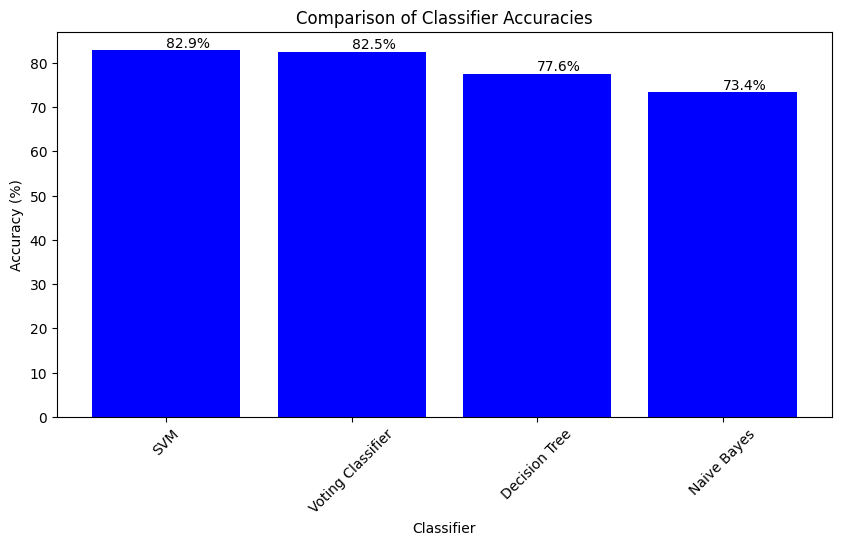

In [44]:
# Hypothetical example data (including duplicates for demonstration)
accuracy = [
    (73.35833333333333, 'Naive Bayes'),
    (77.575, 'Decision Tree'),
    (82.50833333333333, 'Voting Classifier'),
    (82.875, 'SVM'),  # Duplicate entry for demonstration
    
]

# Remove duplicates by converting the list of tuples into a set of tuples, then back to a list
unique_accuracy = [list(t) for t in set(tuple(element) for element in accuracy)]

# Sorting the list by the accuracy score
unique_accuracy.sort(key=lambda x: x[0], reverse=True)

# Unzip into separate lists
scores, labels = zip(*unique_accuracy)

# Plotting
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, scores, color='blue')
plt.xlabel('Classifier')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Classifier Accuracies')
plt.xticks(rotation=45)

# Adding text annotations on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{round(yval, 1)}%", va='bottom')  # va: vertical alignment

plt.show()


In [45]:
accuracy

[(73.35833333333333, 'Naive Bayes'),
 (77.575, 'Decision Tree'),
 (82.50833333333333, 'Voting Classifier'),
 (82.875, 'SVM')]

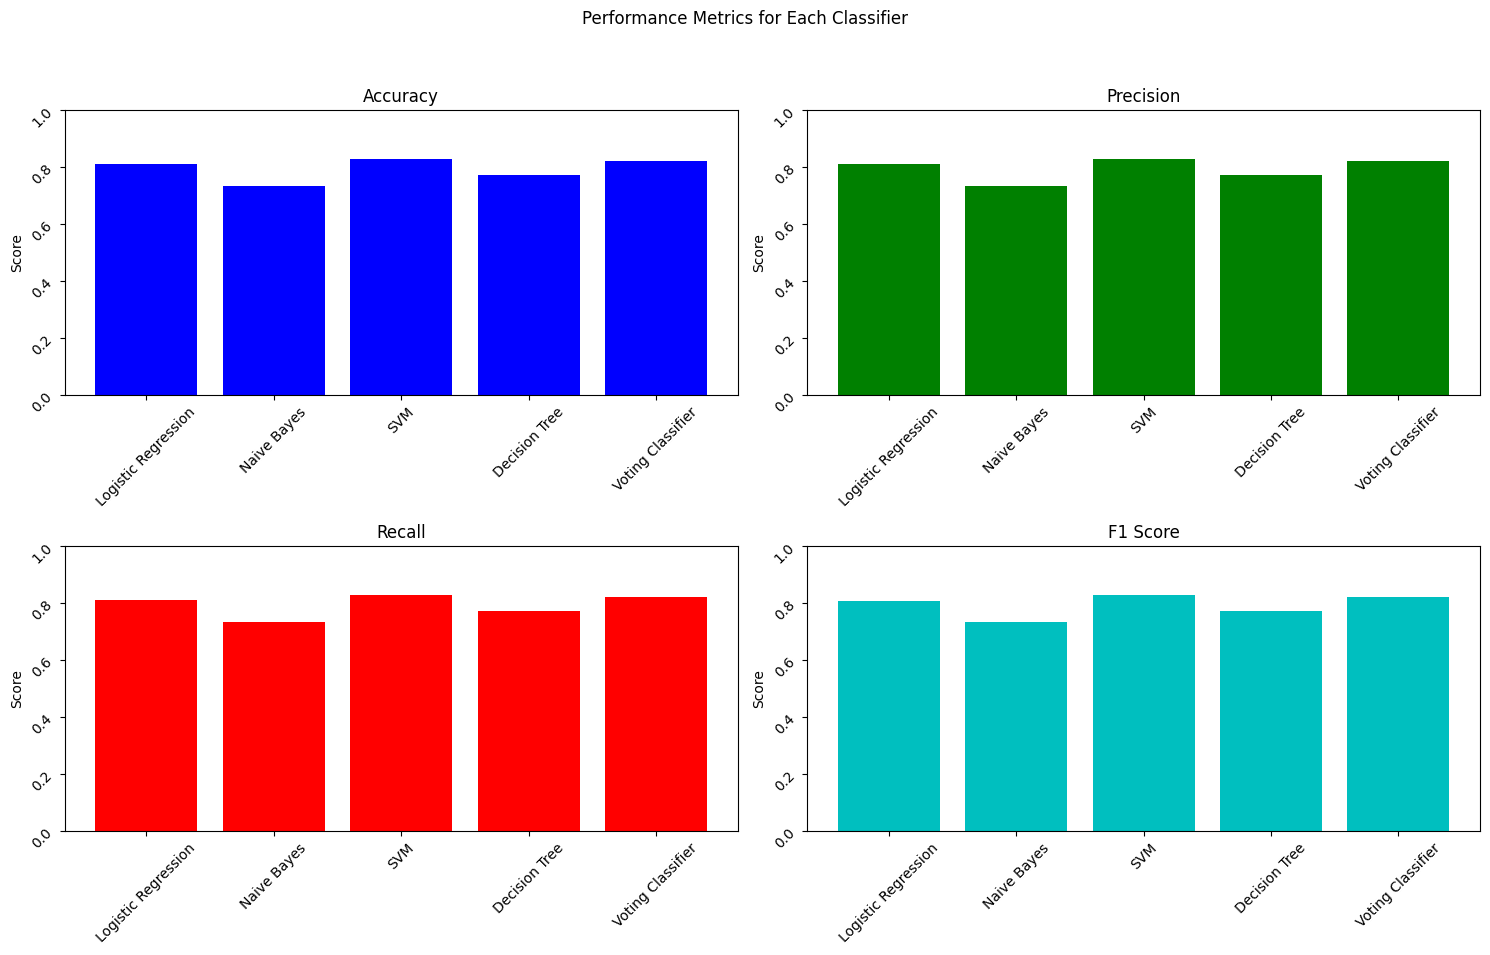

In [46]:
# Initialize dictionary to store metrics
metrics = {
    'Classifier': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# List of classifiers
classifiers = {
    'Logistic Regression': logistic_model,
    'Naive Bayes': naive_bayes_model,
    'SVM': svm_model,
    'Decision Tree': decision_tree_model,
    'Voting Classifier': voting_clf
}

# Evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)  # Train each classifier
    y_pred = clf.predict(X_test)  # Make predictions
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store metrics
    metrics['Classifier'].append(name)
    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1 Score'].append(f1)

# Plotting the metrics
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Performance Metrics for Each Classifier')

# Accuracy Plot
ax[0, 0].bar(metrics['Classifier'], metrics['Accuracy'], color='b')
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_ylabel('Score')
ax[0, 0].set_ylim([0, 1])
ax[0, 0].tick_params(labelrotation=45)

# Precision Plot
ax[0, 1].bar(metrics['Classifier'], metrics['Precision'], color='g')
ax[0, 1].set_title('Precision')
ax[0, 1].set_ylabel('Score')
ax[0, 1].set_ylim([0, 1])
ax[0, 1].tick_params(labelrotation=45)

# Recall Plot
ax[1, 0].bar(metrics['Classifier'], metrics['Recall'], color='r')
ax[1, 0].set_title('Recall')
ax[1, 0].set_ylabel('Score')
ax[1, 0].set_ylim([0, 1])
ax[1, 0].tick_params(labelrotation=45)

# F1 Score Plot
ax[1, 1].bar(metrics['Classifier'], metrics['F1 Score'], color='c')
ax[1, 1].set_title('F1 Score')
ax[1, 1].set_ylabel('Score')
ax[1, 1].set_ylim([0, 1])
ax[1, 1].tick_params(labelrotation=45)

# Layout adjustment
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()


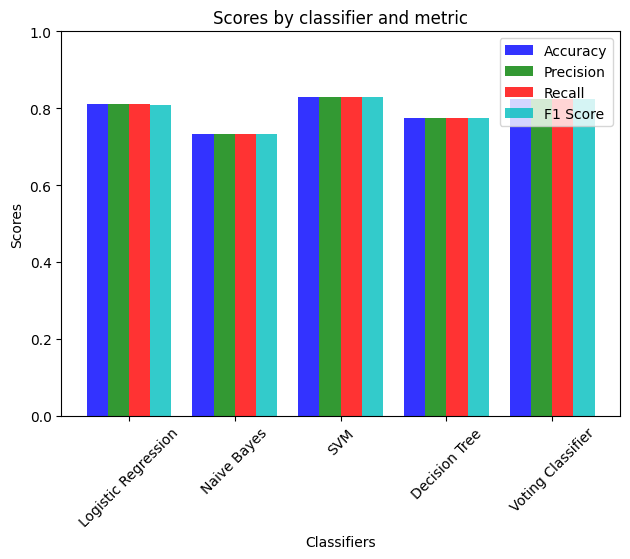

In [47]:
# Prepare the data
classifiers = {
    'Logistic Regression': logistic_model,
    'Naive Bayes': naive_bayes_model,
    'SVM': svm_model,
    'Decision Tree': decision_tree_model,
    'Voting Classifier': voting_clf
}

# Metrics storage
metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)  # Train the classifier
    y_pred = clf.predict(X_test)  # Predict on the test set
    
    # Append each metric
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['Precision'].append(precision_score(y_test, y_pred, average='weighted'))
    metrics['Recall'].append(recall_score(y_test, y_pred, average='weighted'))
    metrics['F1 Score'].append(f1_score(y_test, y_pred, average='weighted'))

# Setting up the bar chart
n_groups = len(classifiers)  # Number of groups
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

# Plot each metric
rects1 = ax.bar(index, metrics['Accuracy'], bar_width,
                alpha=opacity, color='b', label='Accuracy')

rects2 = ax.bar(index + bar_width, metrics['Precision'], bar_width,
                alpha=opacity, color='g', label='Precision')

rects3 = ax.bar(index + 2 * bar_width, metrics['Recall'], bar_width,
                alpha=opacity, color='r', label='Recall')

rects4 = ax.bar(index + 3 * bar_width, metrics['F1 Score'], bar_width,
                alpha=opacity, color='c', label='F1 Score')

# Adding labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Classifiers')
ax.set_ylabel('Scores')
ax.set_title('Scores by classifier and metric')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(classifiers.keys())
ax.legend()

# Layout
fig.tight_layout()
plt.xticks(rotation=45)  # Rotate classifier names for better fit
plt.ylim(0, 1)  # Scale the y-axis to show scores from 0 to 1

# Show plot
plt.show()


# Confusion Matrix with and without Normalization

Confusion matrix, without normalization
[[3116  402  440]
 [ 297 3513  212]
 [ 463  300 3257]]
Normalized confusion matrix
[[0.7872663  0.10156645 0.11116726]
 [0.07384386 0.87344605 0.05271009]
 [0.11517413 0.07462687 0.810199  ]]


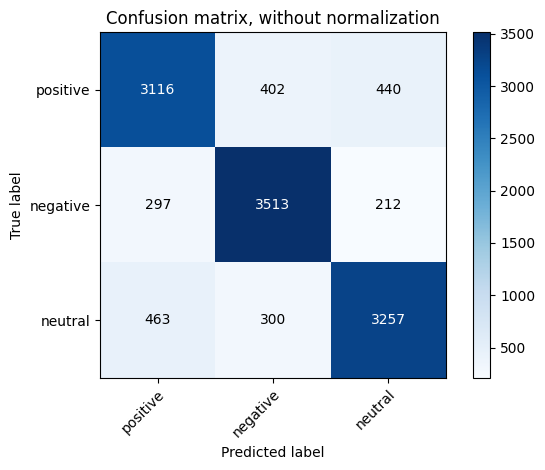

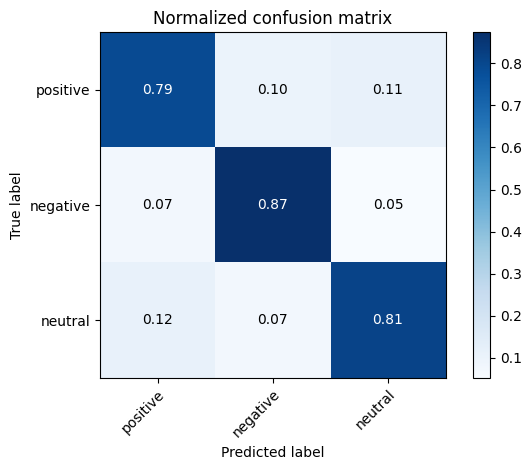

In [48]:
class_names = ['positive', 'negative', 'neutral']

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        title = 'Normalized confusion matrix' if normalize else 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


# Testing Example Sentences using Voting Classifier to predict Sentiment

In [50]:
# Example sentence
example_sentence = "I really enjoyed the movie, it was fantastic!"

# Vectorize the example sentence using the same TF-IDF vectorizer
example_sentence_vectorized = tfidf_vectorizer.transform([example_sentence])

# Predict sentiment using the trained voting classifier
predicted_sentiment = voting_clf.predict(example_sentence_vectorized)

# Format and print the predicted sentiment alongside the example sentence
print(f"{example_sentence} : {predicted_sentiment[0]}")


I really enjoyed the movie, it was fantastic! : positive


In [51]:
# Example sentence
example_sentence = "Weather is so good today"

# Vectorize the example sentence using the same TF-IDF vectorizer
example_sentence_vectorized = tfidf_vectorizer.transform([example_sentence])

# Predict sentiment using the trained voting classifier
predicted_sentiment = voting_clf.predict(example_sentence_vectorized)

# Print the predicted sentiment
print("Weather is so good today:", predicted_sentiment[0])


Weather is so good today: positive


In [53]:
# Example sentence
example_sentence = "aaj ka mausam achha hai"

# Vectorize the example sentence using the same TF-IDF vectorizer
example_sentence_vectorized = tfidf_vectorizer.transform([example_sentence])

# Predict sentiment using the trained voting classifier
predicted_sentiment = voting_clf.predict(example_sentence_vectorized)

# Print the predicted sentiment
print("aaj ka mausam achha hai:", predicted_sentiment[0])


aaj ka mausam achha hai: neutral


In [55]:
# Example sentence
example_sentence = "That movie was really bad"

# Vectorize the example sentence using the same TF-IDF vectorizer
example_sentence_vectorized = tfidf_vectorizer.transform([example_sentence])

# Predict sentiment using the trained voting classifier
predicted_sentiment = voting_clf.predict(example_sentence_vectorized)

# Print the predicted sentiment
print("That movie was really bad:", predicted_sentiment[0])


That movie was really bad: negative


In [56]:
# Example sentence
example_sentence = "Today's weather is good"

# Vectorize the example sentence using the same TF-IDF vectorizer
example_sentence_vectorized = tfidf_vectorizer.transform([example_sentence])

# Predict sentiment using the trained voting classifier
predicted_sentiment = voting_clf.predict(example_sentence_vectorized)

# Print the predicted sentiment
print("Today's weather is good:", predicted_sentiment[0])


Today's weather is good: positive


In [57]:
# Example sentence
example_sentence = "Today's weather is good"

# Vectorize the example sentence using the same TF-IDF vectorizer
example_sentence_vectorized = tfidf_vectorizer.transform([example_sentence])

# Predict sentiment using the trained voting classifier
predicted_sentiment = svm_model.predict(example_sentence_vectorized)

# Print the predicted sentiment
print("Today's weather is good:", predicted_sentiment[0])


Today's weather is good: positive


In [58]:
# Example sentence
example_sentence = "Today's weather is good"

# Vectorize the example sentence using the same TF-IDF vectorizer
example_sentence_vectorized = tfidf_vectorizer.transform([example_sentence])

# Predict sentiment using the trained voting classifier
predicted_sentiment = svm_model.predict(example_sentence_vectorized)

# Print the predicted sentiment
print("Sun rises in the east:", predicted_sentiment[0])


Sun rises in the east: positive
